In [1]:
import h5py
import numpy as np
import corner as DFM
import desispec.io as desiIO
from astropy.table import Table
# --- fomospec ---
from FOMOspec import util as UT
from FOMOspec import fitters as Fitters

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
prosp = Fitters.Prospector()

In [4]:
galid = 1

In [5]:
# read in source spectra (only to get the redshift)
f_name = 'gal_spectrum_'+str(galid)+'_BGS_template_BC03_Stelib.fits'
f_inspec = fits.open(''.join([UT.dat_dir(), 'Lgal/templates/', f_name]))
specin = f_inspec[1].data
wave_in = specin['wave']
flux_in = specin['flux_nodust_nonoise'] * 1e20
zred = f_inspec[0].header['REDSHIFT']

# read desi-like spectra
f_name = 'gal_spectrum_'+str(galid)+'_BGS_template_BC03_Stelib.fits'
f_outspec = ''.join([UT.dat_dir(), 'Lgal/spectra/', 'desi_out_', f_name])
spec_desi = desiIO.read_spectra(f_outspec)

wave = np.concatenate([spec_desi.wave[b] for b in ['b', 'r', 'z']])
flux = np.concatenate([spec_desi.flux[b][0] for b in ['b', 'r', 'z']]) # 10-17 ergs/s/cm2/AA
flux_unc = np.concatenate([spec_desi.ivar[b][0]**-0.5 for b in ['b', 'r', 'z']])

(0.0, 15.0)

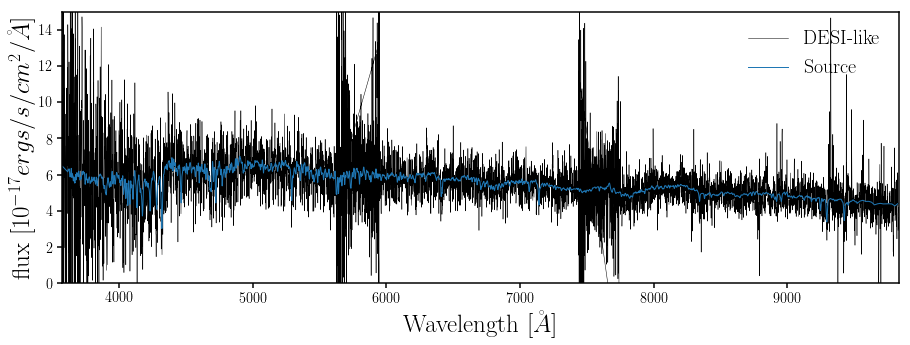

In [6]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(wave, flux, c='k', lw=0.5, label='DESI-like')
sub.plot(wave_in, flux_in, c='C0', lw=1, label='Source')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([wave.min(), wave.max()])
sub.set_ylabel('flux [$10^{-17} ergs/s/cm^2/\AA$]', fontsize=25)
sub.set_ylim([0., 15.])

Read in emcee output

In [7]:
f_desi_mc = ''.join([UT.dat_dir(), 'Lgal/spectra/',
                     'prospector.emcee.masked.desi_out_gal_spectrum_', str(galid), '_BGS_template_BC03_Stelib.h5'])
ef = h5py.File(f_desi_mc, 'r')
desi_chain = ef['sampling']['chain'].value
desi_lnp = ef['sampling']['lnprobability'].value
ef.close()

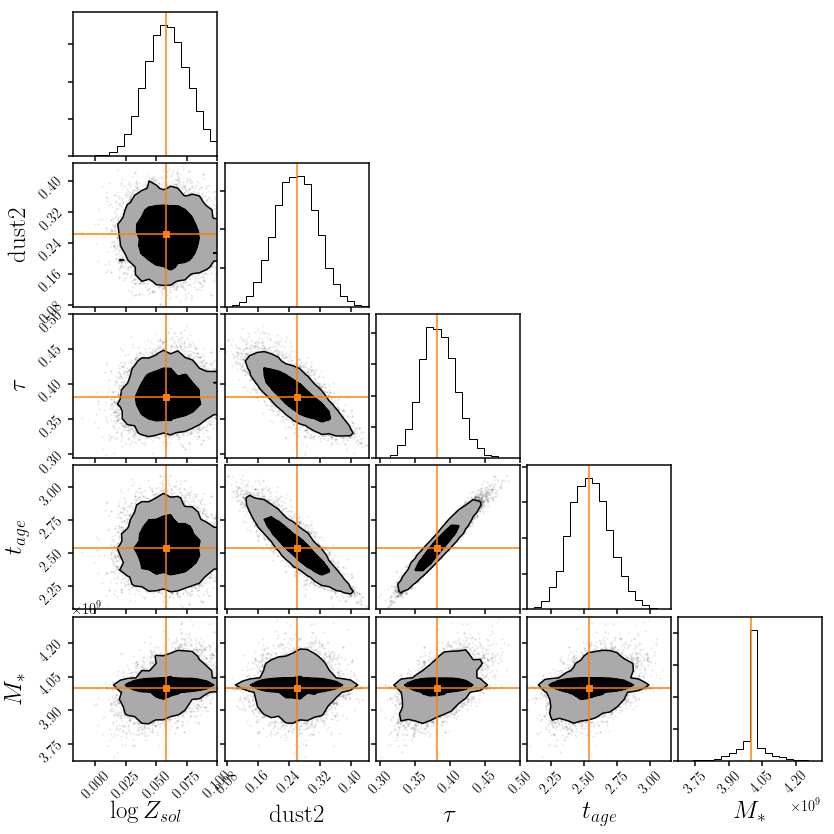

In [9]:
imax = np.argmax(desi_lnp)
i, j = np.unravel_index(imax, desi_lnp.shape)

chain_thin = desi_chain[:,::5,:]
chain_flat = chain_thin.reshape(chain_thin.shape[0] * chain_thin.shape[1], chain_thin.shape[2])

fig = DFM.corner(chain_flat, truths=desi_chain[i,j,:], truth_color='C1', 
                 labels=[r'$\log Z_{sol}$', 'dust2', r'$\tau$', '$t_{age}$', '$M_*$'], 
                 label_kwargs={'fontsize': 25},
                 fill_contours=True, levels=[0.68, 0.95])
tt_map_d = desi_chain[i,j,:]
flux_map, _, _ = prosp.model(wave, tt_map_d, zred)

(0.0, 10.0)

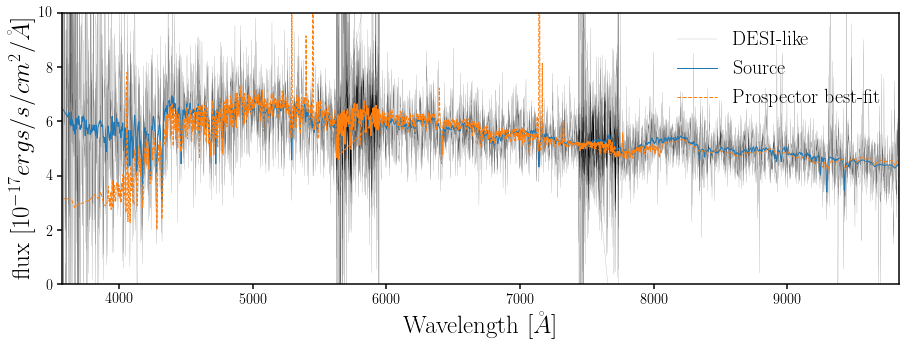

In [10]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(wave, flux, c='k', lw=0.1, label='DESI-like')
sub.plot(wave_in, flux_in, c='C0', lw=1, label='Source')
# MAP m(theta)
sub.plot(wave, flux_map, c='C1', lw=1, ls='--', label='Prospector best-fit')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([wave.min(), wave.max()])
sub.set_ylabel('flux [$10^{-17} ergs/s/cm^2/\AA$]', fontsize=25)
sub.set_ylim([0., 10.])

(2.0, 8.0)

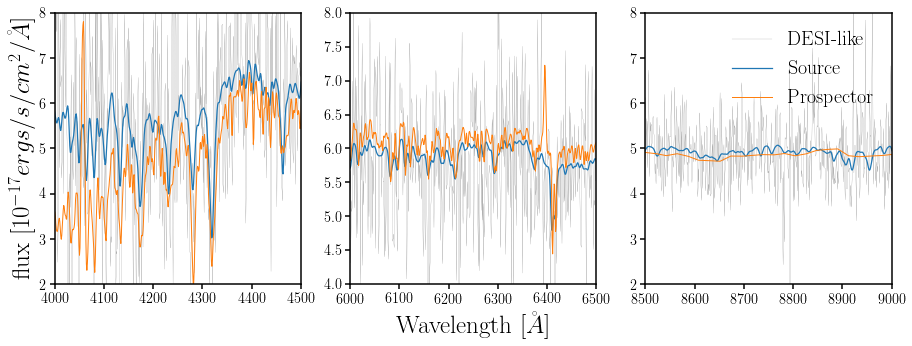

In [44]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.plot(wave, flux, c='k', lw=0.1, label='DESI-like')
sub.plot(wave_in, flux_in, c='C0', lw=1.25, label='Source')
# MAP m(theta)
sub.plot(wave, flux_map, c='C1', lw=1, ls='-', label='MAP')
sub.set_xlim([4e3, 4.5e3])
sub.set_ylabel('flux [$10^{-17} ergs/s/cm^2/\AA$]', fontsize=25)
sub.set_ylim([2., 8.])

sub = fig.add_subplot(132)
sub.plot(wave, flux, c='k', lw=0.1, label='DESI-like')
sub.plot(wave_in, flux_in, c='C0', lw=1.25, label='Source')
# MAP m(theta)
sub.plot(wave, flux_map, c='C1', lw=1, ls='-', label='MAP')
sub.set_xlabel('Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([6e3, 6.5e3])
sub.set_ylim([4., 8.])

sub = fig.add_subplot(133)
sub.plot(wave, flux, c='k', lw=0.1, label='DESI-like')
sub.plot(wave_in, flux_in, c='C0', lw=1.25, label='Source')
# MAP m(theta)
sub.plot(wave, flux_map, c='C1', lw=1, ls='-', label='Prospector ')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlim([8.5e3, 9e3])
sub.set_ylim([2., 8.])

In [46]:
def read_input(galID):
    #reads input star-formation and chemical enrichment histories
    infile = UT.dat_dir() + 'Lgal/gal_inputs/' + 'gal_input_' + str(galID) + '_BGS_template_FSPS_uvmiles.csv'
    gal_input = Table.read(infile, delimiter=' ')
    return gal_input

In [47]:
gal_input = read_input(galid)

In [55]:
chain_flat.shape

(13184, 5)

(0.0, 0.04)

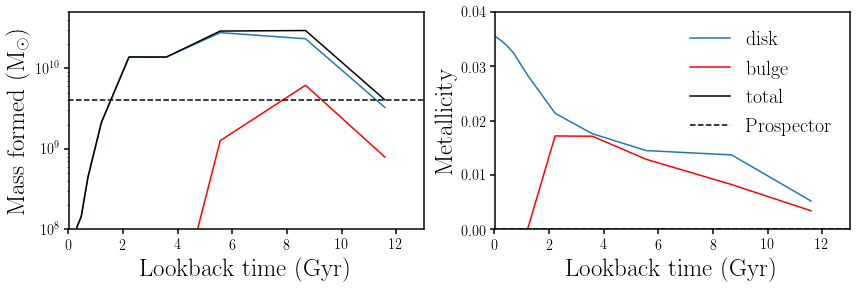

In [79]:
fig = plt.figure(figsize=(14,4))
sub = fig.add_subplot(121)
sub.plot(gal_input['sfh_t'], gal_input['sfh_disk'], color='C0')
sub.plot(gal_input['sfh_t'], gal_input['sfh_bulge'], color='red')
sub.plot(gal_input['sfh_t'], gal_input['sfh_bulge'] + gal_input['sfh_disk'], color='black', label='total')
mmed = np.percentile(chain_flat[:,4], [50])
sub.plot([0., 15.], [mmed, mmed], c='k', ls='--', label='Prospector')
#sub.legend(loc='lower right', fontsize=20)
sub.set_xlabel('Lookback time (Gyr)', fontsize=25)
sub.set_xlim([1e-2, 13.])
sub.set_ylabel(r'Mass formed (M$_\odot$)', fontsize=25)
sub.set_yscale('log')
sub.set_ylim([1e8, 5e10])

sub = fig.add_subplot(122) 
sub.plot(gal_input['sfh_t'], gal_input['Z_disk'], label='disk')
sub.plot(gal_input['sfh_t'], gal_input['Z_bulge'], color='red', label='bulge')
sub.plot([0., 0.], [0., 0.], c='k', ls='-', label='total')
sub.plot([0., 15.], [0., 0.], c='k', ls='--', label='Prospector')
sub.legend(fontsize=20)
sub.set_xlabel('Lookback time (Gyr)', fontsize=25)
sub.set_xlim([1e-2, 13.])
sub.set_ylabel('Metallicity', fontsize=25)
sub.set_ylim([0., 0.04])